In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json

from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.sampling import Condition

import utils.functions as f

import datagenerator.generators.synthesizer as synth

import warnings
warnings.filterwarnings("ignore", message="Warning")

2025-07-04 12:37:13.638500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nlv19419/.pyenv/versions/3.11.12/envs/incartdb-venv/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html



# Method
Given the complexity (and in the present also the confidentiality) of generating synthetic data, we will first explore the issue of bias in the original data in a toy-problem style of working. At a later point in the analysis, we will return to synthetic ECG.


## Data processing
The export from the incart database is based on the header files of that database's format and some light processing in R. We load that file here and then continue the processing because most variables are factors that need to be transformed into numeric features.

In [3]:
dataset = "incartdb_demographics"
df = pd.read_csv(f"{dataset}.csv", sep=",")
df.head(10)

,age,gender,pid,age_bin,diagnosis,present
0,65,F,patient 1,"(60,70]",Coronary artery disease,1
1,65,F,patient 1,"(60,70]",arterial hypertension,1
2,65,F,patient 1,"(60,70]",Acute MI,0
3,65,F,patient 1,"(60,70]",Transient ischemic attack,0
4,65,F,patient 1,"(60,70]",left ventricular hypertrophy,0
5,65,F,patient 1,"(60,70]",Earlier MI,0
6,65,F,patient 1,"(60,70]",Sinus node dysfunction,0
7,59,M,patient 2,"(50,60]",Coronary artery disease,0
8,59,M,patient 2,"(50,60]",arterial hypertension,0
9,59,M,patient 2,"(50,60]",Acute MI,1


In [4]:
df_processed = f.process_full_dataset(df, dataset_name=dataset)
df_processed.head(10)

,age,gender,pid,age_bin,diagnosis,present
0,65,0,patient 1,4,1,1
1,65,0,patient 1,4,5,1
2,65,0,patient 1,4,0,0
3,65,0,patient 1,4,4,0
4,65,0,patient 1,4,6,0
5,65,0,patient 1,4,2,0
6,65,0,patient 1,4,3,0
7,59,1,patient 2,3,1,0
8,59,1,patient 2,3,5,0
9,59,1,patient 2,3,0,1


## Feature correlations
Given that the incart database only contains data from 32 individuals, there's only very few ages that have multiple occurrences. To properly assess aspects of age, we therefore split patients' ages into 10-year bins and proceeded with the analysis using the binned data only. In this data set we observed a moderate correlation between age bin and gender.

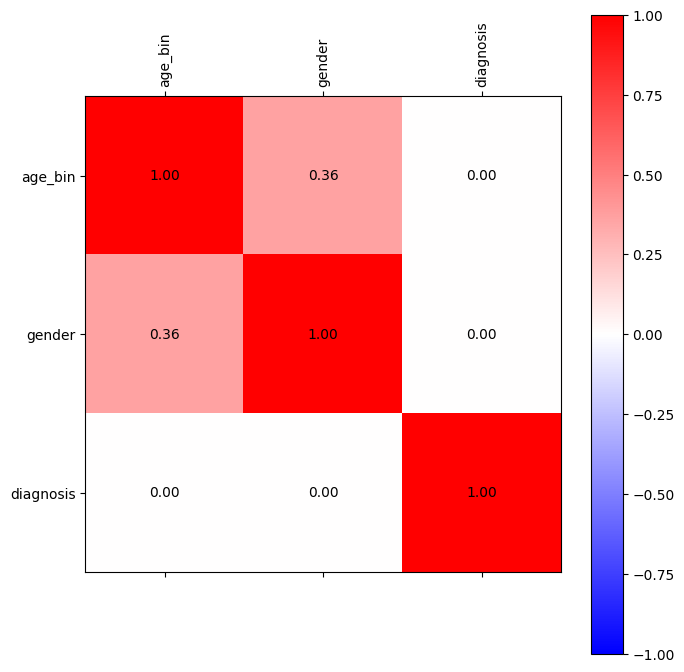

In [5]:
selected_columns = [
    "age_bin",
    "gender", 
    "diagnosis"
]
f.plot_correlation_matrix(df_processed, selected_columns, figsize=(7,7))

## Data overview
After observing the lack of correlation between the individual features, we calculated the probabilities of the individual scores for each feature separately. During the later parts of these analysis, we need to know this information to drive the synthetic data generation.

In [6]:
df_processed.drop_duplicates(subset=['pid', 'gender'])['gender'].value_counts(normalize=True)

gender
1    0.5625
0    0.4375
Name: proportion, dtype: float64

In [7]:
df_processed.drop_duplicates(subset=['pid', 'age_bin'])['age_bin'].value_counts(normalize=True)

age_bin
3    0.34375
4    0.31250
5    0.09375
1    0.09375
2    0.09375
0    0.06250
Name: proportion, dtype: float64

In [8]:
df_processed[df_processed['present'] == 1] \
    .drop_duplicates(subset=['pid', 'diagnosis'])['diagnosis'] \
    .value_counts(normalize=True)

diagnosis
1    0.241379
5    0.241379
4    0.137931
6    0.137931
2    0.137931
0    0.068966
3    0.034483
Name: proportion, dtype: float64

## Analysis plan
This toy data set provides the opportunity to use the Aequitas framework's analyses and bias repair methods on a data set that is easy to comprehend. Of course, the size of the data comes with a fair set of limitations. 

The most important limitation is that we only have positive diagnoses for (most of) the patients but to calculate group-bases bias metrics like disparate impact, having negative diagnoses is an important aspect of the data. The incart database indicates seven individual diagnoses for the patients and each patient has their positive diagnosis listed in the original data. We simply presumed absence of the remaining diagnoses that were not listed for any individual.

We will first assess and repair bias for gender by calculating relevant bias metrics for individual diagnoses and will then repeat the process for the other demographic variable of 5-year age bin.

# Experiment: Bias in Gender
For these analyses we used the encoding of gender listed below. This sets the male gender as priviledged group.

- "Female": 0
- "Male": 1

## Bias detection


In [9]:
gender_bias = f.show_bias(df_processed, "gender", 1, plot_histogram=False)

enc_file = open("utils/encodings/incartdb_demographics_diagnosis_encoding.json")
enc = json.load(enc_file)
reverse_enc = {int(value): key for key, value in enc.items()}
gender_bias['diagnosis'] = gender_bias['diagnosis'].replace(reverse_enc).astype(str)

gender_bias

/Users/nlv19419/.pyenv/versions/3.11.12/envs/incartdb-venv/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning:

divide by zero encountered in scalar divide



,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,0.000000,-0.111111,0.048611
1,Coronary artery disease,7.714286,0.373016,0.163194
2,Earlier MI,0.428571,-0.095238,0.041667
3,Sinus node dysfunction,inf,0.071429,0.031250
4,Transient ischemic attack,0.000000,-0.222222,0.097222
5,arterial hypertension,7.714286,0.373016,0.163194
6,left ventricular hypertrophy,3.857143,0.158730,0.069444



The analysis of disparate impact shows that in this toy data set, women have a higher prevalence for coronoray artery disease, arterial hypertension, or left ventricular hypertrophy. Women, compared to men, are less often diagnosed with acute and earlier MI, and transient ischemic attack. The statistical parity metric confirms these findings with negative scores for the MI and ischemic attack diagnoses that is indicative of a higher prevalence of these diagnoses for men.

## Bias mitigation
Given that we do not have tertiary variables in the data set to use when repairing the bias with a `DisparateImpactRemover()`, we instead use the Aequitas framework synthesizer to create additional data to repair the disparate impact score. Initially, we will use a simple multinomial synthesizer to balance, within each diagnosis, the gender distribution. Afterwards, we will use a more complex sampler to address the full data set (over diagnoses) in one go.

### Univariate synthesis

In [10]:
# diagnoses = sorted(df_processed.diagnosis.unique())

# df_mitigated = df_processed.drop(columns=['header_file', 'id', 'age'])
# cols = ['age_bin']

# df_gender_mitigated = f.compute_bias_differences_percentage(df_processed, diagnoses, 'gender', cols, mode='normal')
# df_gender_mitigated

In [11]:
df_diag1 = df_processed[df_processed['diagnosis'] == 1]
df_diag1 \
    .drop_duplicates(subset=['pid', 'gender'])[['gender', 'present']] \
    .value_counts(normalize=True)

gender  present
1       0          0.53125
0       0          0.25000
        1          0.18750
1       1          0.03125
Name: proportion, dtype: float64

In [12]:
sampler = synth.MultiNomSampler(labels=['M_0', 'F_0', 'F_1', 'M_1'],
                                prob=[0.25, 0.25, 0.25, 0.25])
samples = sampler.sample(75)
df_gen = pd.DataFrame({"var": samples})
df_gen[['gender', 'present']] = df_gen['var'].str.split('_', expand=True)
df_gen['present'] = df_gen['present'].astype(int)
df_gen['diagnosis'] = int(1)
df_gen

,var,gender,present,diagnosis
0,M_0,M,0,1
1,F_0,F,0,1
2,F_1,F,1,1
3,M_1,M,1,1
4,M_1,M,1,1
...,...,...,...,...
70,M_0,M,0,1
71,M_0,M,0,1
72,F_0,F,0,1
73,M_1,M,1,1


In [13]:
df_gen[['gender', 'present']].value_counts(normalize=True) 

gender  present
F       1          0.280000
M       0          0.266667
F       0          0.226667
M       1          0.226667
Name: proportion, dtype: float64

Now, we can recalculate bias (for this instance of diagnosis) and see whether the changed proportion of males affected the metrics.

In [14]:
df_gen = f.transform_gender(df_gen, var="gender")
f.show_bias(df_gen, "gender", 1, plot_histogram=False)

,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,1,1.202786,0.093172,0.047207


The analysis shows that the disparate impact and statistical parity difference can be moved to another value by reducing the number of males without a diagnosis (and increasing those with).

### Using a multivariate approach
Another approach would be to use one of the more complex samplers that can handle all variables at once and determine correlations between variables. **For the moment, we'll use the SDV library for this as it provides a complete experience; this will be wrapped into the Aequitas synthesizer at a later stage.** The SDV library is used to fit a multivariate sampler to the data set comprising the age bin, gender, and diagnosis columns. 

We then polarize the distribution for gender to create a better balance between male and female patients and create a new multivariate sampler with that polarized configuration. From this sampler, we sample the same number of rows and count the number of men and females.

In [15]:
df_multivar = df.drop(columns=['pid', 'age'])
df_multivar['present'] = df_multivar['present'].apply(lambda x: 'present' if x == 1 else 'absent')
df_multivar

,gender,age_bin,diagnosis,present
0,F,"(60,70]",Coronary artery disease,present
1,F,"(60,70]",arterial hypertension,present
2,F,"(60,70]",Acute MI,absent
3,F,"(60,70]",Transient ischemic attack,absent
4,F,"(60,70]",left ventricular hypertrophy,absent
...,...,...,...,...
219,M,"(60,70]",Acute MI,absent
220,M,"(60,70]",Transient ischemic attack,absent
221,M,"(60,70]",left ventricular hypertrophy,absent
222,M,"(60,70]",Earlier MI,present


In [16]:
metadata = Metadata.detect_from_dataframe(data=df_multivar, table_name='df_multivar')

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_multivar)
synthesizer.get_learned_distributions()


/Users/nlv19419/.pyenv/versions/3.11.12/envs/incartdb-venv/lib/python3.11/site-packages/sdv/single_table/base.py:128: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



{'gender': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.0010063780062828226,
   'scale': 0.9973827085544972,
   'a': 1.0400698600076228,
   'b': 0.9898902995114749}},
 'age_bin': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.003238961536658907,
   'scale': 0.9963097238292189,
   'a': 1.0018093717385366,
   'b': 0.9815964416097187}},
 'diagnosis': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.0007765842156322077,
   'scale': 0.9951256594757094,
   'a': 1.0049855964789107,
   'b': 0.9761772631700074}},
 'present': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.0012481741073626929,
   'scale': 0.9967758278635476,
   'a': 0.884793091956704,
   'b': 0.8503640610388988}}}

In [17]:
synthesizer.sample(num_rows=20)

,gender,age_bin,diagnosis,present
0,M,"(50,60]",Acute MI,absent
1,M,"(50,60]",Acute MI,absent
2,M,"(40,50]",Transient ischemic attack,absent
3,M,"(60,70]",Earlier MI,absent
4,M,"(60,70]",left ventricular hypertrophy,absent
5,M,"(50,60]",left ventricular hypertrophy,present
6,M,"(60,70]",Earlier MI,absent
7,M,"(50,60]",Sinus node dysfunction,absent
8,M,"(50,60]",Sinus node dysfunction,absent
9,F,"(70,80]",left ventricular hypertrophy,absent


In [18]:
men = Condition(num_rows=200, column_values={'gender': 'M'})
females = Condition(num_rows=250, column_values={'gender': 'F'})
conditional_df = synthesizer.sample_from_conditions(conditions=[men, females])
conditional_df

Sampling conditions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 7196.54it/s]


,gender,age_bin,diagnosis,present
0,M,"(50,60]",left ventricular hypertrophy,absent
1,M,"(50,60]",Acute MI,absent
2,M,"(50,60]",Coronary artery disease,absent
3,M,"(50,60]",left ventricular hypertrophy,absent
4,M,"(50,60]",Sinus node dysfunction,absent
...,...,...,...,...
445,F,"(0,20]",Coronary artery disease,absent
446,F,"(30,40]",Coronary artery disease,absent
447,F,"(60,70]",Transient ischemic attack,absent
448,F,"(0,20]",Acute MI,present


Now that we have a much better balance between female and male patients, we can evaluate whether this has had effect on disparate impact and statistical parity difference.

In [19]:
df_test = f.process_full_dataset(conditional_df, dataset_name='multivar')
df_test['present'] = (df_test['present'] == 'present').astype(int)

In [20]:
multivar_polarized_bias = f.show_bias(df_test, "gender", 1, plot_histogram=False)
multivar_polarized_bias['diagnosis'] = multivar_polarized_bias['diagnosis'].replace(reverse_enc).astype(str)
multivar_polarized_bias

,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,2.324786,0.116893,0.062450
1,Coronary artery disease,1.367647,0.047438,0.024814
2,Earlier MI,1.187879,0.033550,0.018150
3,Sinus node dysfunction,1.435897,0.062271,0.032819
4,Transient ischemic attack,6.081081,0.203243,0.121290
5,arterial hypertension,3.942857,0.127950,0.077211
6,left ventricular hypertrophy,6.545455,0.231061,0.133772


The table shows that the disparate impact values, except for one are close to 1. Statistical parity is similary close to zero. This indicates that the bias that priviledges men (in the present use case implying more diagnoses of the respective disease) has mostly disappeared. Of course, playing with the exact balance could bring the bias metrics even closer to balance. Note though that with arterial hypertension now being the highest scorer, it may be necessary that the bias is reduced per diagnosis and afterwards combined into one data set for training an algorithm.

# Experiment: Age Bias
For this analysis, we need to handle a feature that has multiple levels. We therefore set age bin number 2 as priviledged group simply by choice.

Enconding:
- "0-20": 0
- "30-40": 1
- "40-50": 2
- "50-60": 3
- "60-70": 4
- "70-80": 5

## Bias detection
Because statistical parity difference and disparate impact can only compare two groups, we carried out 6 separate analyses in which the priviledged age group is compared to one other unpriviledged group.

In [21]:
enc_file = open("utils/encodings/incartdb_demographics_diagnosis_encoding.json")
enc = json.load(enc_file)
reverse_enc = {int(value): key for key, value in enc.items()}

In [22]:
ref_age = 2
for upg in [0, 1, 3, 4, 5]:
    d = df_processed.copy()
    
    print(f"Comparing age bins 2 and {upg}")
    
    d = d[d['age_bin'].isin([ref_age, upg])]
    d["age_bin"] = np.where(d["age_bin"] == upg, 0, d['age_bin']) # make sure to have unpriv. group be zero label.
    
    # display(d[['age_bin', 'diagnosis', 'present']].value_counts())
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        age_bias = f.show_bias(d, "age_bin", ref_age, plot_histogram=False)
        
    age_bias['diagnosis'] = age_bias['diagnosis'].replace(reverse_enc).astype(str)

    display(age_bias)

Comparing age bins 2 and 0


,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,NaN,0.000000,NaN
1,Coronary artery disease,0.0,-0.333333,NaN
2,Earlier MI,NaN,0.000000,NaN
3,Sinus node dysfunction,NaN,0.000000,NaN
4,Transient ischemic attack,NaN,0.000000,NaN
5,arterial hypertension,0.0,-0.333333,NaN
6,left ventricular hypertrophy,NaN,0.000000,NaN


Comparing age bins 2 and 1


,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,NaN,0.000000,NaN
1,Coronary artery disease,1.0,0.000000,NaN
2,Earlier MI,NaN,0.000000,NaN
3,Sinus node dysfunction,NaN,0.000000,NaN
4,Transient ischemic attack,NaN,0.000000,NaN
5,arterial hypertension,1.0,0.000000,NaN
6,left ventricular hypertrophy,inf,0.333333,NaN


Comparing age bins 2 and 3


,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,inf,0.181818,NaN
1,Coronary artery disease,0.818182,-0.060606,NaN
2,Earlier MI,inf,0.090909,NaN
3,Sinus node dysfunction,NaN,0.000000,NaN
4,Transient ischemic attack,inf,0.090909,NaN
5,arterial hypertension,0.818182,-0.060606,NaN
6,left ventricular hypertrophy,inf,0.181818,NaN


Comparing age bins 2 and 4


,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,NaN,0.000000,NaN
1,Coronary artery disease,0.3,-0.233333,NaN
2,Earlier MI,inf,0.200000,NaN
3,Sinus node dysfunction,inf,0.100000,NaN
4,Transient ischemic attack,inf,0.200000,NaN
5,arterial hypertension,0.3,-0.233333,NaN
6,left ventricular hypertrophy,NaN,0.000000,NaN


Comparing age bins 2 and 5


,diagnosis,disparate_impact,statistical_parity_difference,DIDI
0,Acute MI,NaN,0.000000,NaN
1,Coronary artery disease,1.0,0.000000,NaN
2,Earlier MI,inf,0.333333,NaN
3,Sinus node dysfunction,NaN,0.000000,NaN
4,Transient ischemic attack,inf,0.333333,NaN
5,arterial hypertension,1.0,0.000000,NaN
6,left ventricular hypertrophy,inf,0.333333,NaN


The many `NaN` and `Inf` values in the above tables indicate that for the majority of diagnoses, disparate impact could not be calculated. Inspection of the data show that this is due to a paucity of data: not all diagnoses have data points for the age bins that are being compared. 

Considering, for instance, coronary artery disease, we see that except for the 60-70 year olds, the priviledged group (40-50 years old) has reduced probability for the disease. Let's therefore use synthetic data to try and "repair" this priviledge. For the analysis, we can build on the existing model that we fitted before by sampling a larger number of patients and then redoing the bias detection and using polarization to create approximately equal probabilities for each age group.

In [30]:
age0 = Condition(num_rows=200, column_values={'age_bin': '(0,20]'})
age1 = Condition(num_rows=200, column_values={'age_bin': '(30,40]'})
age2 = Condition(num_rows=200, column_values={'age_bin': '(40,50]'})
age3 = Condition(num_rows=200, column_values={'age_bin': '(50,60]'})
age4 = Condition(num_rows=200, column_values={'age_bin': '(60,70]'})
age5 = Condition(num_rows=200, column_values={'age_bin': '(70,80]'})
conditional_df = synthesizer.sample_from_conditions(conditions=[age0, age1, age2, age3, age4, age5])
conditional_df

Sampling conditions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 6318.25it/s]


,gender,age_bin,diagnosis,present
0,F,"(0,20]",Earlier MI,absent
1,F,"(0,20]",Transient ischemic attack,present
2,F,"(0,20]",Sinus node dysfunction,absent
3,M,"(0,20]",Coronary artery disease,absent
4,M,"(0,20]",left ventricular hypertrophy,absent
...,...,...,...,...
1195,F,"(70,80]",Acute MI,absent
1196,M,"(70,80]",arterial hypertension,absent
1197,M,"(70,80]",Acute MI,absent
1198,M,"(70,80]",Sinus node dysfunction,absent


In [31]:
df_test = f.process_full_dataset(conditional_df, dataset_name='multivar')
df_test['present'] = (df_test['present'] == 'present').astype(int)
df_test

,gender,age_bin,diagnosis,present
0,0,0,2,0
1,0,0,4,1
2,0,0,3,0
3,1,0,1,0
4,1,0,6,0
...,...,...,...,...
1195,0,5,0,0
1196,1,5,5,0
1197,1,5,0,0
1198,1,5,3,0


In [33]:
age_bias = pd.DataFrame()

for upg in [0, 1, 3, 4, 5]:
    d = df_test.copy()
    
    print(f"Comparing age bins 2 and {upg}")
    
    d = d[d['age_bin'].isin([ref_age, upg])]
    d["age_bin"] = np.where(d["age_bin"] == upg, 0, d['age_bin']) # make sure to have unpriv. group be zero label.
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = f.show_bias(d, "age_bin", ref_age, plot_histogram=False)
        
    res['diagnosis'] = res['diagnosis'].replace(reverse_enc).astype(str)
    age_bias = pd.concat([age_bias, res], axis=0)

age_bias.groupby('diagnosis')['disparate_impact'].describe()

Comparing age bins 2 and 0
Comparing age bins 2 and 1
Comparing age bins 2 and 3
Comparing age bins 2 and 4
Comparing age bins 2 and 5


,count,mean,std,min,25%,50%,75%,max
diagnosis,,,,,,,,
Acute MI,5.0,1.249580,0.572627,0.703704,0.879630,0.938272,1.747126,1.979167
Coronary artery disease,5.0,0.696762,0.212062,0.568966,0.568966,0.611111,0.665323,1.069444
Earlier MI,5.0,0.508528,0.120607,0.352941,0.461538,0.516129,0.526316,0.685714
Sinus node dysfunction,5.0,0.528859,0.367775,0.173333,0.208000,0.433333,0.866667,0.962963
Transient ischemic attack,5.0,0.878934,0.409777,0.480000,0.692308,0.800000,0.857143,1.565217
arterial hypertension,5.0,0.485104,0.386494,0.000000,0.305556,0.399194,0.717391,1.003378
left ventricular hypertrophy,5.0,0.521377,0.430581,0.138462,0.225000,0.313043,0.778378,1.152000


This approach shows that synthetic data can change the disparate impact and statistical parity scores, although in this case in a scenario that is not realistic. Additionally, with (many) more data points available, the scores that could not be computed in the actual data, now can be computed. Note that this of course is based on a simple presumption that the distribution in the original data reflects the truth despite its relatively small size. In normal circumstances, background data should be sought that gives more current and realistic prevalence distributions for ages and diagnoses.